#  Dummy variable

### Econometrics A (ØkA)

Wooldridge (Ch. 7)

Bertel Schjerning

Department of Economics, University of Copenhagen


### Enable autoreload and read libraries

In [1]:
# Sørger for at alle importerede python filer geninlæses ved import statements
# Nødvedigt, hvis ændinger skal tage effekt uden at genstarte Python Kernel
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import mymlr as mlr # see mymlr.py

# Part 1: Lønreggresion med robuste standardfejl


### Lønregression: Timeløn, uddannelse og erfaring
Estimation af lineær model for timeløn, uddannelse og erfaring:
$$
		\log(\text{wage}_i) = \beta _{0}+ \beta _{1}\text{educ}_i+\beta_{2}\text{experience}_i+\beta _{3}\text{experience}^2_i+\beta_4 \text{kvinde}_i+u_i
$$

### Indlæs data og generer variable

In [3]:
# Indlæs data og generer varibale
df = pd.read_stata(r"../data/wage.dta")   # Load data
# generer andre variable
df['const'] = 1                           # Add constant term
df['lwage'] = np.log(df['wage'])          # Log af timeln
df['experience2'] = df['experience'] ** 2 # tilføj experience²
df['kvinde'] = (df['sex']==2).astype(int) # Dummy for kvinde
df['min_udd'] =  (df['educ']<10).astype(int)
df['klasse10'] =  (df['educ']==10).astype(int)
df['ung_udd'] =  ((df['educ'] > 10) & (df['educ'] <= 13)).astype(int)
df['videre_udd'] =  (df['educ']>13).astype(int)

### Robust varians-kovarians matrix og standard fejl
Estimator for varians-covarians matrix for $\hat{\boldsymbol\beta}$ under **homoscedasticitet** (MLR.5)
$$
	\widehat{\text{Var}}(\hat{\boldsymbol\beta}|\mathbf{X})=\hat{\sigma}^2(\mathbf{X^{\prime }X})^{-1}
$$
Med tilhørende standardfejl:
$$
	\widehat{se}(\hat{\boldsymbol\beta}|\mathbf{X})
	=\sqrt{\text{diag}(\widehat{\text{Var}}(\hat{\boldsymbol\beta}|\mathbf{X}))}.
$$

<br>

**Heteroscedasticity konsistent estimator** for varians-covarians matrix for $\hat{\boldsymbol\beta}$
$$
	\widehat{\text{Var}_{robust}}(\hat{\boldsymbol\beta}|\mathbf{X})=\frac{1}{n-k}(\mathbf{(X^{\prime }X)}/n)^{-1}\hat{\boldsymbol\Sigma}(\mathbf{X^{\prime}X}/n)^{-1}
$$
hvor 
$$
\hat{\boldsymbol\Sigma}=\frac{1}{n}\sum_{i=1}^{n}\hat{u}_{i}^{2}\mathbf{x_{i}^{\prime}x_{i}}
$$
Vi har justeret for antal frihedsgrader ($n-k$), hvor $k$ antal forklarende variable inclusive konstantleddet

Med tilhørende heteroskedasticitisk-konsistente standardfejl:
$$
\widehat{se_{robust}}(\hat{\boldsymbol\beta}|\mathbf{X})
	=\sqrt{\text{diag}(\widehat{\text{Var}_{robust}}(\hat{\boldsymbol\beta}|\mathbf{X}))}.
$$


### Robuste varians-kovarians matrix og standard fejl

In [4]:
# Funktion til at beregne varians-kovarians matrix (OLS eller HCSE afhængig af 'robust')
def var_beta(residuals, X, robust=False):
    inv=np.linalg.inv
    n, k = X.shape
    if robust:
        # HCSE: heteroskedasticity-consistent varians-kovarians matrix
        Ainv = inv(X.T @ X / n)  # Beregn Ainv
        Sigma = (X* (residuals**2)).T  @ X / n  # Matrix for beregning af Σ  
        return Ainv @ Sigma @ Ainv / (n - k)  # Returner HCSE varians-kovarians matrix
    else:
        # OLS varians-kovarians matrix under homoskedasticitet
        sigma2 = np.sum(residuals**2) / (n - k)  # Estimeret fejlledsvarians
        return sigma2 * inv(X.T @ X)  # Returner standard OLS varians-kovarians matrix

# Estimer model med OLS, og gem residualer 
X = df[['const', 'educ', 'experience', 'experience2', 'kvinde']] 
y=df['lwage']
m_hom = mlr.ols(X, y)    # estimer model med ols
uhat = m_hom['residuals']# gem ols residualer 

# Beregn OLS og HCSE varians-kovarians matrice
var_beta_hom = var_beta(uhat, X, robust=False)  # Standard OLS (homoskedasticitet)
var_beta_hcse = var_beta(uhat, X, robust=True)  # Heteroskedasticitets-konsistent (HCSE)
print(f'OLS standard fejl\n {np.sqrt(np.diag(var_beta_hom))}')
print(f'\nRobuste standard fejl (HCSE)\n {np.sqrt(np.diag(var_beta_hcse))}')

OLS standard fejl
 [0.0386674  0.00251424 0.00375595 0.00011535 0.01713255]

Robuste standard fejl (HCSE)
 [0.05381284 0.00325569 0.00417416 0.00011886 0.01725109]


### Nu også implementeret i mymlr

In [5]:
import mymlr as mlr # see mymlr.py
m_hom = mlr.ols(df[['const', 'educ', 'experience', 'experience2', 'kvinde']], df['lwage'])
m_het = mlr.ols(df[['const', 'educ', 'experience', 'experience2', 'kvinde']], df['lwage'], robust=True)
mlr.summary([m_hom, m_het])

                    Model 1  Model 2
Dependent variable    lwage    lwage
             const   4.4169   4.4169
                   (0.0387) (0.0538)
              educ   0.0271   0.0271
                   (0.0025) (0.0033)
        experience   0.0279   0.0279
                   (0.0038) (0.0042)
       experience2  -0.0006  -0.0006
                   (0.0001) (0.0001)
            kvinde  -0.1888  -0.1888
                   (0.0171) (0.0173)
         R_squared   0.2843   0.2843
               TSS 111.2507 111.2507
               RSS  79.6240  79.6240
               ESS  31.6267  31.6267
                 n     1078     1078


### Sammenligning af resultater (OLS standardfejl og robuste standardfejl)

- **Model 1** anvender OLS-standardfejl, der forudsætter homoskedasticitet (konstant varians i residualer).
- **Model 2** bruger HCSE, der justerer for heteroskedasticitet (varierende residualvarians).
- HCSE-standardfejlene er generelt større, især for konstantleddet og `educ`, hvilket tyder på heteroskedasticitet i data.
- Koeficientestimaterne er uændrede mellem modellerne, da OLS forbliver middelret trods heteroskedasticitet.
- HCSE sikrer mere robuste standardfejl og pålidelige inferens, når der er tegn på heteroskedasticitet.

- Vi vil senere se på formelle test for heteroskedasticitet, og analysere hvilke forklarende variable der er variansstyrende

# Part 2: Wald test med (og uden) robuste standardfejl


## The Wald-test

Wald-teststørrelsen (Se Wooldridge E-4a):
$$
    W = (\mathbf{R\hat{\boldsymbol\beta} - r})^{\prime} 
    \left[ \mathbf{R} \widehat{var}(\hat{\boldsymbol\beta}|\mathbf{X}) \mathbf{R^{\prime}} \right]^{-1}
    (\mathbf{R\hat{\boldsymbol\beta} - r}) \sim \chi^2(q),
$$
- $\mathbf{R}$ er en $q \times (k+1)$ restriktionsmatrice,
- $\mathbf{r}$ er en $q \times 1$ vektor.

Vi estimerer en urestrikteret model for den lineære effekt af uddannelse og uddannelsesdummies:

$$
\log(\text{wage}) = \beta_{0} + \delta _{1}\text{klasse10} + \delta_{2}\text{ung.udd} + \delta_{3}\text{videreg.udd}
+ \beta_{1}\text{uddannelse} + \beta_{2}\text{erfaring} + \beta_{3}\text{erfaring}^{2} + \beta _{4}\text{kvinde} + u.
$$

Vi ønsker at teste nulhypotesen:
$$
H_0: \delta_{1}=\delta_{2}=\delta_{3}=0
$$

Vores restriktionsmatrix $\mathbf{R}$ og vector $\mathbf{r}$ bliver:
$$
\mathbf{R} = \begin{pmatrix}
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0
\end{pmatrix}, \quad
\mathbf{r} = \begin{pmatrix}
0 \\
0 \\
0
\end{pmatrix}.
$$

### Let's code - Wald test

In [6]:
import numpy as np
from scipy.stats import chi2

def wald_test(beta_hat, var_beta_hat, R, r):
    """
    Funktion til at beregne Wald-teststørrelsen.
    
    Parametre:
    beta_hat (np.array): Estimater af koefficienter (k x 1).
    var_beta_hat (np.array): Varians-kovarians matrix for beta (k x k).
    R (np.array): Restriktionsmatrix (q x k).
    r (np.array): Restriktionsvektor (q x 1).
    
    Returnerer:
    W (float): Wald-teststørrelsen.
    p_value (float): p-værdien for teststørrelsen.
    """
    # Sørg for, at beta_hat er en kolonnevektor
    beta_hat = beta_hat.reshape(-1, 1)  # (k+1 x 1)
    
    # Sørg for, at r er en kolonnevektor
    r = r.reshape(-1, 1)  # (q x 1)
    
    # Udregn forskellen mellem R * beta_hat og r
    Rb_minus_r = R @ beta_hat - r  # (q x 1)
    
    # Beregn Wald-teststørrelsen
    W = (Rb_minus_r.T @ np.linalg.inv(R @ var_beta_hat @ R.T) @ Rb_minus_r).item()  # Skalar

    # Returner teststørrelsen og p-værdien baseret på en chi2 fordeling
    return W, 1 - chi2.cdf(W, df=R.shape[0])

### Step 1: Estimer den urestrikterede model

In [7]:
Xvar= ['const','klasse10', 'ung_udd', 'videre_udd',  'educ', 'experience', 'experience2','kvinde']
m_hom=mlr.ols(df[Xvar], df['lwage'], robust=False)
m_het=mlr.ols(df[Xvar], df['lwage'], robust=True)
mlr.summary([m_hom, m_het])

                    Model 1  Model 2
Dependent variable    lwage    lwage
             const   4.6259   4.6259
                   (0.0463) (0.0564)
          klasse10  -0.0574  -0.0574
                   (0.0350) (0.0378)
           ung_udd   0.0467   0.0467
                   (0.0373) (0.0403)
        videre_udd   0.2880   0.2880
                   (0.0549) (0.0602)
              educ   0.0023   0.0023
                   (0.0055) (0.0062)
        experience   0.0279   0.0279
                   (0.0036) (0.0039)
       experience2  -0.0006  -0.0006
                   (0.0001) (0.0001)
            kvinde  -0.1839  -0.1839
                   (0.0164) (0.0165)
         R_squared   0.3474   0.3474
               TSS 111.2507 111.2507
               RSS  72.6070  72.6070
               ESS  38.6437  38.6437
                 n     1078     1078


### Step 2: Formuler $\mathbf{R}$  og  $\mathbf{r}$ for vores specifikke nulhypotese:  
Urestrikteret model
$$
\log(\text{wage}) = \beta_{0} + \delta _{1}\text{klasse10} + \delta_{2}\text{ung.udd} + \delta_{3}\text{videreg.udd}
+ \beta_{1}\text{uddannelse} + \beta_{2}\text{erfaring} + \beta_{3}\text{erfaring}^{2} + \beta _{4}\text{kvinde} + u.
$$
Nulhypotese
$$H_0: \delta_1 = \delta_2 = \delta_3 = 0$$

In [8]:
#Hypotesetest: H0: δ1 = δ2 = δ3 = 0
R = np.array([[0, 1, 0, 0, 0, 0, 0, 0],  # δ1
              [0, 0, 1, 0, 0, 0, 0, 0],  # δ2
              [0, 0, 0, 1, 0, 0, 0, 0]])  # δ3
r = np.array([0, 0, 0])  # Vores restriktionsvektor (alle lig nul)

### Step 3: Udfør wald test

In [9]:
# Beregn Wald-testet for m_het (med heteroskedastiske robuste standardfejl)
W_het, p_value_het = wald_test(m_het['beta_hat'], m_het['var_beta_hat'], R, r)
print(f"Heteroskedastisk Wald-test: W = {W_het}, p-værdi = {p_value_het}")

# Gør det samme for den homoskedastiske model (m_hom)
W_hom, p_value_hom = wald_test(m_hom['beta_hat'], m_hom['var_beta_hat'], R, r)
print(f"Homoskedastisk Wald-test: W = {W_hom}, p-værdi = {p_value_hom}")

Heteroskedastisk Wald-test: W = 93.9452023468522, p-værdi = 0.0
Homoskedastisk Wald-test: W = 103.40803785251683, p-værdi = 0.0


### Flere Wald tests 

In [10]:
print(f"Hypotesetest: H0: δ1 = 0, δ2 = δ3")
R = np.array([[0, 1, 0, 0, 0, 0, 0, 0],  # δ1
              [0, 0, 1, -1, 0, 0, 0, 0]]) # δ2 - δ3
r = np.array([0, 0])  # Vores restriktionsvektor (alle lig nul)
W_het, p_value_het = wald_test(m_het['beta_hat'], m_het['var_beta_hat'], R, r)
print(f"Heteroskedastisk Wald-test: W = {W_het}, p-værdi = {p_value_het}")
W_hom, p_value_hom = wald_test(m_hom['beta_hat'], m_hom['var_beta_hat'], R, r)
print(f"Homoskedastisk Wald-test: W = {W_hom}, p-værdi = {p_value_hom}")

print(f"Hypotesetest: H0: δ2 = 0")
R = np.array([[0, 0, 1, 0, 0, 0, 0, 0]]) # δ2
r = np.array([0])  # Vores restriktionsvektor (alle lig nul)
W_het, p_value_het = wald_test(m_het['beta_hat'], m_het['var_beta_hat'], R, r)
print(f"Heteroskedastisk Wald-test: W = {W_het}, p-værdi = {p_value_het}")
W_hom, p_value_hom = wald_test(m_hom['beta_hat'], m_hom['var_beta_hat'], R, r)
print(f"Homoskedastisk Wald-test: W = {W_hom}, p-værdi = {p_value_hom}")


Hypotesetest: H0: δ1 = 0, δ2 = δ3
Heteroskedastisk Wald-test: W = 93.93031932623133, p-værdi = 0.0
Homoskedastisk Wald-test: W = 102.54569502319228, p-værdi = 0.0
Hypotesetest: H0: δ2 = 0
Heteroskedastisk Wald-test: W = 1.3461024096285268, p-værdi = 0.2459606562431087
Homoskedastisk Wald-test: W = 1.5725872818668056, p-værdi = 0.20983167516947476


# Part 3:  Breusch-Pagan og White tests for heteroscedasticitet


### Simuler data

In [11]:
# Generer og forbered data
np.random.seed(0)
x = 2 + 4 * np.random.rand(400)
y = 2 + 3 * x
uA = np.random.normal(0, 0.25 + 0.75 * (x - 2), size=len(x))
uB = np.random.normal(0, 1, size=len(x))
uC = np.random.normal(0, 2.5, size=len(x))
uD = np.random.normal(0, 0.25 + 0.75 * (6 - x), size=len(x))
data = pd.DataFrame({'x': x, 'yA': y + uA, 'yB': y + uB, 'yC': y + uC, 'yD': y + uD, 'const': 1})
yvar = ['yA', 'yB', 'yC', 'yD']
xvar = ['x', 'x', 'x', 'x']
labels = ['A', 'B', 'C', 'D']

### Funktion til at plotte y, residualer, og kvadrede residualer (skip)

In [12]:
# Kompakt funktion til at plotte flere variable
import matplotlib.pyplot as plt
def plot_regression(df, xvar, yvar, axs, mode='scatter', labels=None):
    if labels is None:
        labels = yvar
    
    # Gennemløb for hver variabel (f.eks. yA, yB, osv.)
    for i, y_col in enumerate(yvar):
        row, col = divmod(i, 2)  # Arranger plottene i et 2x2 grid
        ax = axs[row, col]
        
        # Estimer OLS ved hjælp af mymlr
        res = mlr.ols(df[['const', xvar[i]]], df[y_col])
        
        x = df[xvar[i]]
        
        # Plot afhængig af mode (scatter, residuals eller squared residuals)
        if mode == 'y':
            ax.scatter(x, df[y_col], color='navy', alpha=0.4)
            ax.plot(x, res['y_hat'], color='darkred')
        elif mode == 'residuals':
            ax.scatter(x, res['residuals'], color='navy', alpha=0.4)
            ax.plot(x, np.zeros_like(x), color='darkred')
        elif mode == 'squared residuals':
            ax.scatter(x, res['residuals']**2, color='navy', alpha=0.4)
            ax.plot(x, np.zeros_like(x), color='darkred')
        
        # Tilføj titel og aksetiketter
        ax.set_title(labels[i], fontsize=14)
        ax.set_xlim([2, 6])
        ax.set_xlabel('x')
        ax.set_ylabel(mode)

    # Optimer layout og gem plottet
    plt.tight_layout()
    plt.savefig(f'examples/Heteroskedasticitet_{mode}.pdf')
    plt.show()


### Plot $y$ mod $x$

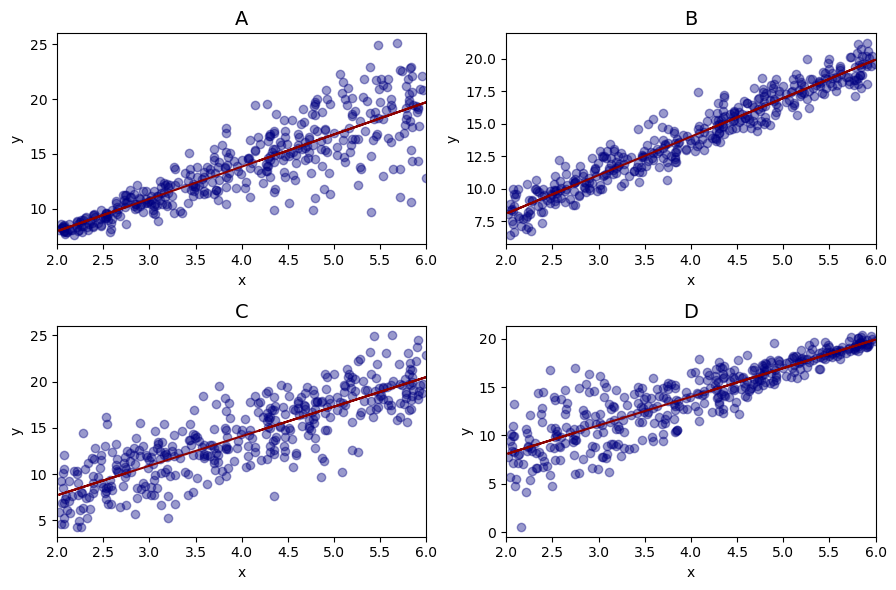

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6))  # Opret subplot for hvert mode
plot_regression(data, xvar, yvar, axs, mode='y', labels=labels)  # Kald funktionen for hvert mode


### Plot  $\hat{u}$ mod $x$

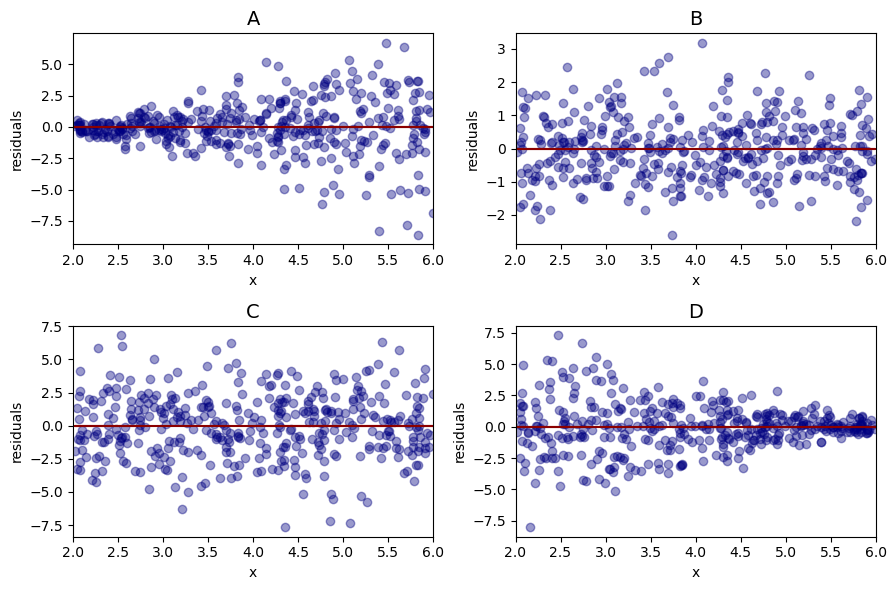

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6))  # Opret subplot for hvert mode
plot_regression(data, xvar, yvar, axs, mode='residuals', labels=labels)  # Kald funktionen for hvert mode


### Plot  $\hat{u}^2$ mod $x$

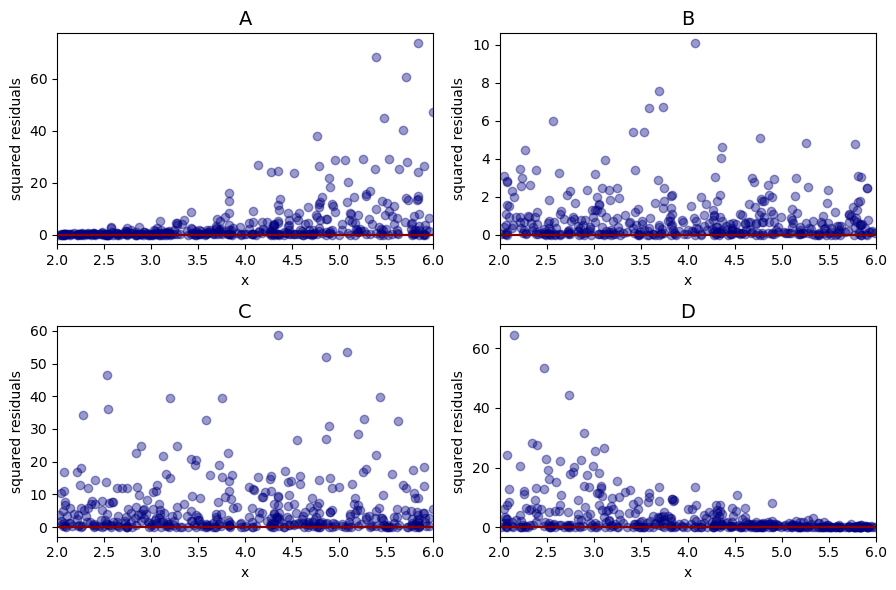

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6))  # Opret subplot for hvert mode
plot_regression(data, xvar, yvar, axs, mode='squared residuals', labels=labels)  # Kald funktionen for hvert mode

### Breusch-Pagan test

In [16]:
def breusch_pagan_test(df, y_col, x_col):
    # Estimer OLS modellen og gem residualerne
    res = mlr.ols(df[[x_col, 'const']], df[y_col])
    residuals = res['residuals']

    # Kvadrerede residualer
    df['u2'] = residuals ** 2

    # Estimer en model med de kvadrerede residualer som afhængig variabel
    aux_model = mlr.ols(df[[x_col, 'const']], df['u2'])
    r_squared = aux_model['R_squared']

    # Antal observationer (n) og antal forklarende variable (k)
    n = len(df)
    k = len(df.columns) - 1  # minus 'y'

    # Beregn LM-teststørrelsen (Breusch-Pagan test)
    LM_stat = n * r_squared
    return LM_stat, 1 - chi2.cdf(LM_stat, df=k-1)  # Returner LM-statistikken og p-værdi

# Brug af funktionen til yA, yB, yC og yD
for y_col in ['yA', 'yB', 'yC', 'yD']:
    LM_stat, p_value = breusch_pagan_test(data, y_col, 'x')
    print(f"Breusch-Pagan test for {y_col}: LM-stat = {LM_stat:.2f}, p-værdi = {p_value:.4f}")


Breusch-Pagan test for yA: LM-stat = 65.81, p-værdi = 0.0000
Breusch-Pagan test for yB: LM-stat = 1.25, p-værdi = 0.9396
Breusch-Pagan test for yC: LM-stat = 0.01, p-værdi = 1.0000
Breusch-Pagan test for yD: LM-stat = 62.46, p-værdi = 0.0000


### Breusch-Pagan test

In [17]:
from scipy.stats import chi2
# Funktion til White's test
def whites_test(df, y_col, x_col):
    # Estimer den originale model med OLS for at få residualer og forudsagte værdier
    res = mlr.ols(df[[x_col, 'const']], df[y_col])
    residuals = res['residuals']  # OLS residualer
    y_hat = res['y_hat'].flatten()  # Forudsagte værdier, flad ud
    y_hat_squared = y_hat ** 2  # Kvadrerede forudsagte værdier

    # Konstruer de kvadrerede residualer
    df["u2"] = residuals ** 2

    # Hjælperegression for White's test: brug $\hat{y}$ og $\hat{y}^2$
    aux_df = pd.DataFrame({'y_hat': y_hat, 'y_hat_squared': y_hat_squared, 'const': np.ones_like(y_hat)})
    
    # Estimer hjælperegressionen med OLS
    aux_model = mlr.ols(aux_df[['const', 'y_hat', 'y_hat_squared']], df["u2"])
    
    # Beregn R^2 fra hjælperegressionen
    r_squared = aux_model['R_squared']
    
    # Antal observationer (n) og antal forklarende variable (k)
    n = len(df)
    k = 2  # Der er to regressorer: $\hat{y}$ og $\hat{y}^2$
    
    # Beregn LM-teststørrelsen for White's test
    LM_stat = n * r_squared
    p_value = 1 - chi2.cdf(LM_stat, df=k)
    
    return LM_stat, p_value

# Kør White's test på data (for yA, yB, yC, yD)
for y_col in ['yA', 'yB', 'yC', 'yD']:
    LM_stat, p_value = whites_test(data, y_col, 'x')
    print(f"White's test for {y_col}: LM-stat = {LM_stat:.2f}, p-værdi = {p_value:.4f}")

White's test for yA: LM-stat = 70.91, p-værdi = 0.0000
White's test for yB: LM-stat = 1.34, p-værdi = 0.5108
White's test for yC: LM-stat = 0.59, p-værdi = 0.7463
White's test for yD: LM-stat = 63.14, p-værdi = 0.0000
